# Advanced Deep Learning
## Assignment #1
:
intro-dl의 Assignment 6-3 (https://github.com/duneag2/intro-dl/blob/main/Assignment6/seungeun/Assignment6-3.ipynb) 을 baseline으로 아이디어를 추가해 성능이 개선된 모델을 "연구"

## 3. Image Classification w/ pre-trained ResNet model -- custom dataset

Reference. https://github.com/Justin-A/DeepLearning101/blob/master/4-6_Transfer_Learning.ipynb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/adv-dl/hymenoptera_data

/content/drive/MyDrive/adv-dl/hymenoptera_data


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [4]:
# 런타임 - 런타임 유형 변경 - T4 GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.4.0+cu121  Device: cpu


In [5]:
BATCH_SIZE = 32
EPOCHS = 10

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/adv-dl/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, shuffle = True) for x in ['train', 'val']}

In [ ]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type()) #[batch size, channel, height,width]
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


In [ ]:
y_train

tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0])

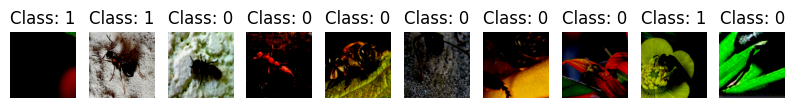

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1) #(nrows, ncols, index)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0))) # (channel, height, width) -> (height, width, channel)
    plt.title('Class: ' + str(y_train[i].item())) #item(): 텐서에서 단일 값 추출하여 python 기본 자료형으로 변환

In [7]:
import torchvision.models as models
model = models.resnet34(pretrained = True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 113MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
for parameter in model.parameters():
    parameter.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        )

model = model.to(DEVICE)

intro-dl 과제를 했을 때,
pretrained=True인 resnet34가 loss가 가장 낮고 , accuracy가 가장 높았기 때문에 이 모델을 baseline model으로 설정하고 실험해보았다.baseline의 optimizer는 Adam이고 lr = 0.001이다.

우선, optimizer를 Adam에서 SGD나 RMSprop로 변경해 가며 성능을 테스트 하였다.


---


Baseline model: **test loss: 0.6618, test accuracy: 65.99**

---


###1. optimizer 변경: Adam->SGD



In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9, weight_decay=1e-4)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [9]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE, dtype=torch.float)
            label = label.to(DEVICE, dtype=torch.float)
            output = model(image).squeeze(dim=1)
            test_loss += criterion(output, label).item()
            output1 = output.cpu()
            output1[output1 >= 0.5] = 1
            output1[output1 < 0.5] = 0
            correct += output1.eq(label.cpu()).int().sum()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.822810
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.666648
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.638592

[EPOCH: 1], 	Test Loss: 0.7141, 	Test Accuracy: 60.96 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.687389
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.756016
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.698597

[EPOCH: 2], 	Test Loss: 0.7057, 	Test Accuracy: 57.93 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.678708
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.646466
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.605272

[EPOCH: 3], 	Test Loss: 0.7004, 	Test Accuracy: 61.21 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.661333
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.597470
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.643713

[EPOCH: 4], 	Test Loss: 0.6983, 	Test Accuracy: 60.96 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.688597
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.614378
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.673921



---


Baseline model: **test loss: 0.6618, test accuracy: 65.99%**

---



SGD(lr = 0.001, momentum=0.9, weight_decay=1e-4): test Loss: 0.6646, 	test Accuracy: 63.98%


---



기존 baseline model보다 accuracy 변동폭이 작아졌지만, highest accuracy는 더 낮았다.

hyperparameter 값을 변화시키면 결과가 달라지는 지를 확인하기 위해서 작은 momentum으로 바꾸어(0.9->0.1) 다시 실행해보았다.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.1, weight_decay=1e-4)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.602279
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.585054
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.607637

[EPOCH: 1], 	Test Loss: 0.6591, 	Test Accuracy: 63.98 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.628406
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.664081
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.685371

[EPOCH: 2], 	Test Loss: 0.6570, 	Test Accuracy: 65.24 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.633533
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.545614
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.616465

[EPOCH: 3], 	Test Loss: 0.6508, 	Test Accuracy: 63.22 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.622749
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.708561
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.634395

[EPOCH: 4], 	Test Loss: 0.6543, 	Test Accuracy: 65.24 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.572716
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.690016
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.649141



---


Baseline model: test loss: 0.6618, **test accuracy: 65.99%**

---



SGD(lr = 0.001, momentum=0.9, weight_decay=1e-4): test Loss: 0.6646, 	test Accuracy: 63.98%


SGD(lr = 0.001, momentum=0.1, weight_decay=1e-4): **test loss:0.6543**, test accuracy: 65.24%

---

 batch size를 16으로 줄이고 weight_decay를 1e-4에서 1e-5로 바꾸어서 실험 해보았다.

In [ ]:
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type()) #[batch size, channel, height,width]
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.1, weight_decay=1e-5)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.923849
Train Epoch: 1 [80/397 (20%)]	Train Loss: 0.560717
Train Epoch: 1 [160/397 (40%)]	Train Loss: 0.627517
Train Epoch: 1 [240/397 (60%)]	Train Loss: 0.510591
Train Epoch: 1 [320/397 (80%)]	Train Loss: 0.658611

[EPOCH: 1], 	Test Loss: 0.6931, 	Test Accuracy: 58.19 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.753062
Train Epoch: 2 [80/397 (20%)]	Train Loss: 0.731320
Train Epoch: 2 [160/397 (40%)]	Train Loss: 0.630530
Train Epoch: 2 [240/397 (60%)]	Train Loss: 0.828810
Train Epoch: 2 [320/397 (80%)]	Train Loss: 0.772355

[EPOCH: 2], 	Test Loss: 0.6849, 	Test Accuracy: 59.19 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.715593
Train Epoch: 3 [80/397 (20%)]	Train Loss: 0.624175
Train Epoch: 3 [160/397 (40%)]	Train Loss: 0.640065
Train Epoch: 3 [240/397 (60%)]	Train Loss: 0.648675
Train Epoch: 3 [320/397 (80%)]	Train Loss: 0.758636

[EPOCH: 3], 	Test Loss: 0.6899, 	Test Accuracy: 58.69 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.667707
Train 



---


Baseline model: test loss: 0.6618, **test accuracy: 65.99%**

---



SGD(lr = 0.001, momentum=0.9, weight_decay=1e-4): test Loss: 0.6646, 	test Accuracy: 63.98%


SGD(lr = 0.001, momentum=0.1, weight_decay=1e-4): **test loss:0.6543**, test accuracy: 65.24%


SGD(lr = 0.001, momentum=0.1, weight_decay=1e-5), batch size=16: test loss:0.6714, test accuracy: 61.46%

---

성능이 나빠져서.....batch size 때문인 것 같으니 다시 32로 되돌려놓았다 ㅜㅜ

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type()) #[batch size, channel, height,width]
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.1, weight_decay=1e-5)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.645180
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.636380
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.652386

[EPOCH: 1], 	Test Loss: 0.6984, 	Test Accuracy: 60.71 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.615645
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.662946
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.724314

[EPOCH: 2], 	Test Loss: 0.6894, 	Test Accuracy: 60.96 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.635296
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.648083
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.827444

[EPOCH: 3], 	Test Loss: 0.6953, 	Test Accuracy: 61.71 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.698391
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.623513
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.639199

[EPOCH: 4], 	Test Loss: 0.6925, 	Test Accuracy: 61.46 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.679219
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.669753
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.626017



---


Baseline model: test loss: 0.6618, **test accuracy: 65.99%**

---



SGD(lr = 0.001, momentum=0.9, weight_decay=1e-4): test Loss: 0.6646, 	test Accuracy: 63.98%


SGD(lr = 0.001, momentum=0.1, weight_decay=1e-4): **test loss:0.6543**, test accuracy: 65.24%


SGD(lr = 0.001, momentum=0.1, weight_decay=1e-5), batch size=16: test loss:0.6714, test accuracy: 61.46%

SGD(lr = 0.001, momentum=0.1, weight_decay=1e-5), batch size=32:0.6910 test loss:, test accuracy: 62.22%


---

###2. optimizer 변경: Adam->RMSprop


In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.734543
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.794544
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.707553

[EPOCH: 1], 	Test Loss: 0.6873, 	Test Accuracy: 61.46 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.600292
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.676011
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.662011

[EPOCH: 2], 	Test Loss: 0.7633, 	Test Accuracy: 61.46 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.797143
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.722428
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.702863

[EPOCH: 3], 	Test Loss: 0.8310, 	Test Accuracy: 43.32 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.791803
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.789238
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.711107

[EPOCH: 4], 	Test Loss: 0.7097, 	Test Accuracy: 61.96 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.747727
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.635014
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.690678



---


Baseline model: test loss: 0.6618, **test accuracy: 65.99%**

---



SGD(lr = 0.001, momentum=0.9, weight_decay=1e-4): test Loss: 0.6646, 	test Accuracy: 63.98%


SGD(lr = 0.001, momentum=0.1, weight_decay=1e-4): test loss:0.6543, test accuracy: 65.24%


SGD(lr = 0.001, momentum=0.1, weight_decay=1e-5), batch size=16: test loss:0.6714, test accuracy: 61.46%

SGD(lr = 0.001, momentum=0.1, weight_decay=1e-5), batch size=32:0.6910 test loss:, test accuracy: 62.22%

RMSprop(lr=0.001, weight_decay=1e-4): **test loss:0.6434**, test accuracy: 65.49%

---

In [11]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.754688
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.845037
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.920149

[EPOCH: 1], 	Test Loss: 0.7269, 	Test Accuracy: 61.46 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.629313
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.560619
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.614447

[EPOCH: 2], 	Test Loss: 0.6751, 	Test Accuracy: 62.72 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.663336
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.783182
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.754916

[EPOCH: 3], 	Test Loss: 0.6868, 	Test Accuracy: 61.96 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.747226
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.632411
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.781610

[EPOCH: 4], 	Test Loss: 0.6731, 	Test Accuracy: 63.48 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.748864
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.640849
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.605160



---


Baseline model: test loss: 0.6618, test accuracy: 65.99%

---



SGD(lr = 0.001, momentum=0.9, weight_decay=1e-4): test Loss: 0.6646, 	test Accuracy: 63.98%


SGD(lr = 0.001, momentum=0.1, weight_decay=1e-4): test loss:0.6543, test accuracy: 65.24%


SGD(lr = 0.001, momentum=0.1, weight_decay=1e-5), batch size=16: test loss:0.6714, test accuracy: 61.46%

SGD(lr = 0.001, momentum=0.1, weight_decay=1e-5), batch size=32:0.6910 test loss:, test accuracy: 62.22%

RMSprop(lr=0.001, weight_decay=1e-4): test loss:0.6434, test accuracy: 65.49%

RMSprop(lr=0.001, weight_decay=1e-5): **test loss:0.6409, test accuracy: 67.00%**

---

weight decay만 1e-4에서 1e-5로 약간 변화를 주었는데 모델 accuracy가 많이 올라가서 신기했다 ㅎ

Best accuracy가 나왔기 때문에 앞으로 이 optimizer를 사용한 모델을 baseline으로 실험을 진행한다

##learning rate scheduler 만들기
:학습 중에 학습률을 동적으로 조절하기 위한 도구
###1. StepLR
일정한 스텝마다 학습률 감소시킴

In [10]:
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [11]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)

In [16]:
#매 10 epoch마다 학습률을 0.1배로 감소
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [17]:
def train(model, train_loader, optimizer, scheduler, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

    scheduler.step()

In [18]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, scheduler, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.602277
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.761889
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.664733

[EPOCH: 1], 	Test Loss: 0.6677, 	Test Accuracy: 63.73 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.694545
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.537917
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.603479

[EPOCH: 2], 	Test Loss: 0.6692, 	Test Accuracy: 63.73 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.609855
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.606105
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.602797

[EPOCH: 3], 	Test Loss: 0.7537, 	Test Accuracy: 61.96 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.758157
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.621227
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.624617

[EPOCH: 4], 	Test Loss: 0.6774, 	Test Accuracy: 62.72 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.561153
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.654064
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.609666

생각해보니까 epoch이 10개인데 매 10개의 epoch마다 learning rate가 줄어들도록 잘못 설정했다 ㅋㅋ ㅜㅜ

그런데 왜 accuracy가 더 상승한거지...??

일단 baseline model에서 건든게 없으니까 이걸 baseline으로 재설정한 후에 3개 epoch마다 learning rate 줄어들도록 StepLR를 적용해봐야겠다

In [16]:
#매 3 epoch마다 학습률을 0.1배로 감소
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
def train(model, train_loader, optimizer, scheduler, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

    scheduler.step()

In [18]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, scheduler, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.710006
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.798664
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.769559

[EPOCH: 1], 	Test Loss: 0.6929, 	Test Accuracy: 60.45 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.661661
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.908406
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.916044

[EPOCH: 2], 	Test Loss: 0.6861, 	Test Accuracy: 62.22 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.738652
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.641030
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.740844

[EPOCH: 3], 	Test Loss: 0.6778, 	Test Accuracy: 62.22 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.648921
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.579748
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.567723

[EPOCH: 4], 	Test Loss: 0.6691, 	Test Accuracy: 62.72 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.529083
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.618990
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.613827



---


Baseline model: **test loss:0.6264, test accuracy: 70.78%**


---

StepLR(step_size=10,gamma=0.1): test loss:0.6624, test accuracy: 63.22%

---





###2. Exponential LR
학습률을 매 epoch마다 일정 비률 감소시킴

In [20]:
# 매 epoch마다 학습률을 0.95배로 감소
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
def train(model, train_loader, optimizer, scheduler, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

    scheduler.step()

In [22]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, scheduler, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.729539
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.678701
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.483197

[EPOCH: 1], 	Test Loss: 0.6754, 	Test Accuracy: 63.48 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.682044
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.513108
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.793599

[EPOCH: 2], 	Test Loss: 0.7088, 	Test Accuracy: 56.68 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.660592
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.608414
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.531200

[EPOCH: 3], 	Test Loss: 0.6447, 	Test Accuracy: 63.48 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.595393
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.700877
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.634289

[EPOCH: 4], 	Test Loss: 0.6464, 	Test Accuracy: 66.25 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.671611
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.532611
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.659184


---


Baseline model: **test loss:0.6264, test accuracy: 70.78%**


---

StepLR(step_size=10,gamma=0.1): test loss:0.6624, test accuracy: 63.22%

ExponentialLR(gamma=0.95): test loss:0.6320, test accuracy: 68.01%

---






###3. ReduceLROnPlateau
모델의 성능이 일정 시간 동안 개선되지 않으면 학습률 감소

In [23]:
# 검증 손실이 개선되지 않으면 학습률 감소
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
def train(model, train_loader, optimizer, scheduler, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

    # ReduceLROnPlateau는 .step()에 검증 손실을 전달해야 함
    scheduler.step(valid_loss)

In [27]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, scheduler, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.590300
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.589931
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.822227

[EPOCH: 1], 	Test Loss: 0.6155, 	Test Accuracy: 67.00 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.531696
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.522847
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.637101

[EPOCH: 2], 	Test Loss: 0.7913, 	Test Accuracy: 48.87 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.646641
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.553314
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.623615

[EPOCH: 3], 	Test Loss: 0.7138, 	Test Accuracy: 56.68 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.688147
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.513526
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.629092

[EPOCH: 4], 	Test Loss: 0.6171, 	Test Accuracy: 65.24 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.605901
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.539158
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.639893


---


Baseline model: test loss:0.6264, **test accuracy: 70.78%**


---

StepLR(step_size=10,gamma=0.1): test loss:0.6624, test accuracy: 63.22%

ExponentialLR(gamma=0.95): test loss:0.6320, test accuracy: 68.01%

ReduceLROnPlateau(mode='min', factor=0.1, patience=10): **test loss:0.5972**, test accuracy: 69.52%



---

###4. Cosine AnnealingLR
학습률이 코사인 곡선을 따라 감소하는 방식

In [28]:
# 10 에포크 동안 코사인 곡선을 따름
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
def train(model, train_loader, optimizer, scheduler, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

    scheduler.step()

In [30]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, scheduler, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.494741
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.773905
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.733091

[EPOCH: 1], 	Test Loss: 0.5943, 	Test Accuracy: 71.28 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.594208
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.611279
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.554132

[EPOCH: 2], 	Test Loss: 0.6031, 	Test Accuracy: 70.03 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.587600
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.622747
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.617125

[EPOCH: 3], 	Test Loss: 0.5942, 	Test Accuracy: 72.54 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.618463
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.511780
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.739503

[EPOCH: 4], 	Test Loss: 0.6637, 	Test Accuracy: 63.48 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.636332
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.618966
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.627638


---


Baseline model: test loss:0.6264, test accuracy: 70.78%


---

StepLR(step_size=10,gamma=0.1): test loss:0.6624, test accuracy: 63.22%

ExponentialLR(gamma=0.95): test loss:0.6320, test accuracy: 68.01%

ReduceLROnPlateau(mode='min', factor=0.1, patience=10): test loss:0.5972, test accuracy: 69.52%

CosineAnnealingLR(T_max=10): **test loss:0.5942, test accuracy: 72.54%**


---

첫번째 epoch부터 best accuracy를 넘어선 걸 보니까..

런타임이 이어지면 training이 리셋이 안 되고 계속 이어져서 학습률이 새로운 환경에서 시작하더라도 accuracy가 높게 나오는걸까..?!

###5. LambdaLR
사용자 정의 함수에 따라 학습률을 조정할 수 있는 스케줄러

In [ ]:
# 10 에포크 동안 코사인 곡선을 따름
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.BCELoss()

print(model)

In [31]:
# epoch에 따라 학습률이 점진적으로 감소
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
lambda_func = lambda epoch: 0.95 ** epoch
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
criterion = nn.BCELoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
def train(model, train_loader, optimizer, scheduler, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

    scheduler.step()

In [33]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, scheduler, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.577403
Train Epoch: 1 [160/397 (38%)]	Train Loss: 0.691740
Train Epoch: 1 [320/397 (77%)]	Train Loss: 0.532791

[EPOCH: 1], 	Test Loss: 0.6742, 	Test Accuracy: 63.48 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.675387
Train Epoch: 2 [160/397 (38%)]	Train Loss: 0.536544
Train Epoch: 2 [320/397 (77%)]	Train Loss: 0.461414

[EPOCH: 2], 	Test Loss: 0.6174, 	Test Accuracy: 68.26 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.526323
Train Epoch: 3 [160/397 (38%)]	Train Loss: 0.556397
Train Epoch: 3 [320/397 (77%)]	Train Loss: 0.533242

[EPOCH: 3], 	Test Loss: 0.6255, 	Test Accuracy: 67.00 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.551254
Train Epoch: 4 [160/397 (38%)]	Train Loss: 0.646094
Train Epoch: 4 [320/397 (77%)]	Train Loss: 0.614953

[EPOCH: 4], 	Test Loss: 0.7078, 	Test Accuracy: 62.72 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.526039
Train Epoch: 5 [160/397 (38%)]	Train Loss: 0.397772
Train Epoch: 5 [320/397 (77%)]	Train Loss: 0.525472


---


Baseline model: test loss:0.6264, test accuracy: 70.78%


---

StepLR(step_size=10,gamma=0.1): test loss:0.6624, test accuracy: 63.22%

ExponentialLR(gamma=0.95): test loss:0.6320, test accuracy: 68.01%

ReduceLROnPlateau(mode='min', factor=0.1, patience=10): test loss:0.5972, test accuracy: 69.52%

CosineAnnealingLR(T_max=10): **test loss:0.5942, test accuracy: 72.54%**

LambdaLR(lr_lambda=lambda_func): test loss:0.5955, test accuracy: 71.54%



---

###결론 및 소감
optimizer를 RMSprop으로 바꾸고 weight_decay를 1e-5로 조정한 후에 learning rate scheduler를 Cosine AnnealingLR로 만드니까 원래 intro-dl에서 model은 test loss가 0.6618에서 0.5942로 감소하고, test accuracy가 65.99에서 72.54로 증가했다. 환경을 조금 변화 시키면 모델의 성능을 향상시킬 수 있다는 것이 재미있었다.

실험을 하면서 든 생각은.. 모델 기능 향상을 위해서 할 수 있는 일은 무한으로 많은데, 다 해보다 보면 끝이 없어서 이 실험을 언제 끝내는게 적절한 것인지 정하는 게 어려운 일이라고 생각했다.

+열심히 하긴했는데 뭔가 실험에 잘못된 점이 있는 것 같다.

모델링의 영향으로 accuracy가 올라간건지, 아니면 훈련을 반복하니까 성능이 좋아진건지 판단이 어려웠다. 이게 만약 잘못한 것이라면 어떻게 해야됐던건지가 궁금하다.